<a href="https://colab.research.google.com/github/Irenee123/MenstrualHealth_Chatbot/blob/main/MenstrualHealthbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# STEP 1  INSTALL & IMPORT LIBRARIES
!pip install transformers datasets tensorflow sentencepiece --quiet

import pandas as pd
import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from sklearn.model_selection import train_test_split

# STEP 2  LOAD DATASET FROM DRIVE
train_path = '/content/drive/My Drive/dataset/Training Data.csv'
test_path  = '/content/drive/My Drive/dataset/Testing Data.csv'

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("✅ Training data shape:", train_df.shape)
print("✅ Testing data shape:", test_df.shape)
train_df.head()


✅ Training data shape: (530, 2)
✅ Testing data shape: (45, 2)


,instruction (string),output (string)
0,What is a normal menstrual cycle length?,A normal menstrual cycle typically ranges from...
1,What are common causes of irregular periods?,Common causes of irregular periods include hor...
2,How can I alleviate menstrual cramps?,Menstrual cramps can be alleviated through var...
3,What are the signs of a heavy menstrual flow?,Signs of a heavy menstrual flow include soakin...
4,Is it normal to experience mood swings during ...,"Yes, it is common for some individuals to expe..."


In [3]:
# STEP 2  DATA PREPROCESSING

# Rename columns to simpler names
train_df = train_df.rename(columns={
    'instruction (string)': 'Question',
    'output (string)': 'Answer'
})
test_df = test_df.rename(columns={
    'instruction (string)': 'Question',
    'output (string)': 'Answer'
})

# Drop missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Convert text to lowercase and strip spaces
train_df['Question'] = train_df['Question'].astype(str).str.lower().str.strip()
train_df['Answer'] = train_df['Answer'].astype(str).str.lower().str.strip()

test_df['Question'] = test_df['Question'].astype(str).str.lower().str.strip()
test_df['Answer'] = test_df['Answer'].astype(str).str.lower().str.strip()

# Prepare data in T5 format
train_df['input_text'] = "question: " + train_df['Question']
train_df['target_text'] = train_df['Answer']

test_df['input_text'] = "question: " + test_df['Question']
test_df['target_text'] = test_df['Answer']

print("✅ Cleaned and formatted training data:")
train_df.head()


✅ Cleaned and formatted training data:


,Question,Answer,input_text,target_text
0,what is a normal menstrual cycle length?,a normal menstrual cycle typically ranges from...,question: what is a normal menstrual cycle len...,a normal menstrual cycle typically ranges from...
1,what are common causes of irregular periods?,common causes of irregular periods include hor...,question: what are common causes of irregular ...,common causes of irregular periods include hor...
2,how can i alleviate menstrual cramps?,menstrual cramps can be alleviated through var...,question: how can i alleviate menstrual cramps?,menstrual cramps can be alleviated through var...
3,what are the signs of a heavy menstrual flow?,signs of a heavy menstrual flow include soakin...,question: what are the signs of a heavy menstr...,signs of a heavy menstrual flow include soakin...
4,is it normal to experience mood swings during ...,"yes, it is common for some individuals to expe...",question: is it normal to experience mood swin...,"yes, it is common for some individuals to expe..."


In [5]:
# STEP 3  TOKENIZATION & DATASET PREPARATION

from transformers import T5Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Define a helper function to tokenize data
def tokenize_function(df, tokenizer, max_input_length=256, max_target_length=256):
    input_encodings = tokenizer(
        list(df['input_text']),
        padding='max_length',
        truncation=True,
        max_length=max_input_length,
        return_tensors='tf'
    )
    target_encodings = tokenizer(
        list(df['target_text']),
        padding='max_length',
        truncation=True,
        max_length=max_target_length,
        return_tensors='tf'
    )
    return input_encodings, target_encodings

# Tokenize train and test sets
train_inputs, train_targets = tokenize_function(train_df, tokenizer)
test_inputs, test_targets = tokenize_function(test_df, tokenizer)

print(" Tokenization completed successfully.")
print("Train input IDs shape:", train_inputs['input_ids'].shape)
print("Test input IDs shape:", test_inputs['input_ids'].shape)


 Tokenization completed successfully.
Train input IDs shape: (530, 256)
Test input IDs shape: (45, 256)


In [6]:
# STEP 4  FINE-TUNE T5 MODEL ON MENSTRUAL HEALTH DATA

from transformers import TFT5ForConditionalGeneration
import tensorflow as tf

# Load the pre-trained T5-small model
model = TFT5ForConditionalGeneration.from_pretrained('t5-small', use_safetensors=False)

# Prepare TensorFlow dataset
BATCH_SIZE = 4
EPOCHS = 2  # you can increase later if you have enough Colab runtime

# Create decoder_input_ids by shifting the target_ids to the right
decoder_input_ids = train_targets['input_ids'][:, :-1]
decoder_attention_mask = train_targets['attention_mask'][:, :-1]

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_inputs['input_ids'],
        'attention_mask': train_inputs['attention_mask'],
        'decoder_input_ids': decoder_input_ids,
        'decoder_attention_mask': decoder_attention_mask
    },
    train_targets['input_ids'][:, 1:] # Shift target labels as well
))
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)

# Define optimizer and loss
# The model compile expects the optimizer as a string identifier.
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile model
model.compile(optimizer='adam', loss=loss_fn) # Pass optimizer as string

# Train model
history = model.fit(train_dataset, epochs=EPOCHS)

print(" Training complete.")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/242M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1/2
133/133 [==============================] - 68s 183ms/step - loss: 0.6415
Epoch 2/2
133/133 [==============================] - 27s 200ms/step - loss: 0.3151
 Training complete.


In [7]:
#  SAVE THE TRAINED MODEL

# Define the path to save the model in Google Drive
save_path = '/content/drive/My Drive/dataset/t5_menstrual_health_model'

# Save the trained model
model.save_pretrained(save_path)

print(f" Model saved successfully to: {save_path}")

 Model saved successfully to: /content/drive/My Drive/dataset/t5_menstrual_health_model


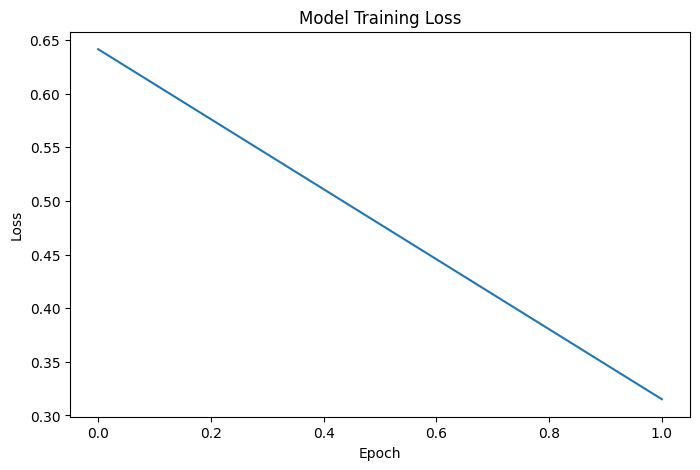

In [20]:
# Visualize Training Loss

import matplotlib.pyplot as plt

# Check if history object exists and has the 'loss' key
if 'history' in locals() and 'loss' in history.history:
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'])
    plt.title('Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
else:
    print("Training history not available for visualization.")

In [22]:
# Clear all cell outputs to avoid issues with notebook rendering on platforms like GitHub
from IPython.display import clear_output
clear_output(wait=True)

print(" All cell outputs cleared.")

 All cell outputs cleared.


In [ ]:
# STEP 5  EVALUATION METRICS

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to generate answers from the trained model
def generate_answer(model, tokenizer, question, max_length=256):
    input_ids = tokenizer("question: " + question.lower(), return_tensors="tf").input_ids
    outputs = model.generate(input_ids, max_length=max_length, num_beams=2, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# BLEU score evaluation on test set
smooth_fn = SmoothingFunction().method1
bleu_scores = []

for q, ref in zip(test_df['Question'], test_df['Answer']):
    pred = generate_answer(model, tokenizer, q)
    reference = [ref.split()]
    candidate = pred.split()
    bleu = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
    bleu_scores.append(bleu)

print(" Average BLEU score on test set:", sum(bleu_scores)/len(bleu_scores))